In [1]:
import zipfile
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from keras.preprocessing.text import text_to_word_sequence,one_hot,Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
import tensorflow as tf
import keras
import keras_self_attention
from keras.layers import Input,Dense,LSTM,Dropout,Embedding, GlobalAveragePooling1D
from keras.layers import Bidirectional, Flatten, SpatialDropout1D, GlobalMaxPool1D,TimeDistributed
from keras.models import Sequential

from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from keras_self_attention import SeqSelfAttention
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, LSTM, Flatten, concatenate
from keras.models import Model

import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import twitter_samples

plt.style.use('seaborn')


# nltk.download('twitter_samples')
# nltk.download('vader_lexicon')

# get 5000 posivie and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

analyzer = SentimentIntensityAnalyzer()
TWEET_LEN = 50
VOCAB_SIZE = 10000
wv_dim = 200
MAXLEN = 64
drop_rate = 0.2

Using TensorFlow backend.


In [2]:

def build_df(x_path, y_path):
    df= pd.read_json(x_path, orient='values',lines=True)


    def find_length(l):
        # print(len([i for i in l if i is not None]))
        return len([i for i in l if i is not None])

    def find_hashtags(x):
        def extract_info(x):
            x = x['entities']['hashtags']
            return [i['text'] for i in x]
        return extract_info(x)
    #
    def find_id_str(x):
        return x["id_str"]


    def find_sentimental_score(x):
        dic = SentimentIntensityAnalyzer().polarity_scores(x)
        dic.pop('compound')
        return sorted(dic.items(), key=lambda i:i[1])[0][0]
    df['tweet_length'] = df.T.agg(find_length)

    df['id_str'] = df[0].map(find_id_str)
    df['hashtags'] = df[0].map(find_hashtags)
    df['text'] = df[0].map(lambda x: x['text'])
    df['sentimental_score'] = df['text'].map(find_sentimental_score)

    def build_y(y_path):
        df = pd.read_json(y_path, orient='values',lines=True).T
        df.columns = ['label']
        return df

    X_label = build_y(y_path)

    df = df.merge(X_label, left_on='id_str', right_index=True)
    return df[['id_str','hashtags','text','sentimental_score','tweet_length','label']]

# df = build_df('project-data/covid.data.jsonl', 'covid_timeDistributed_lstm_without_weight.zip')
# df
# df.to_csv('covid_df.csv')

In [3]:
import ast

df = pd.read_csv('covid_df.csv', index_col=0)
df['hashtags'] = df['hashtags'].map(ast.literal_eval)
df

,id_str,hashtags,text,sentimental_score,tweet_length,label
0,1272262651100434433,[Tenet],"According to the New York Times, Warner Bros. ...",pos,1,non-rumour
1,1287153210990395392,[],Hurricane Hanna has made landfall in Texas.\n\...,neg,2,non-rumour
2,1266555444283179008,[],Monkeys on the loose in India with stolen coro...,pos,1,non-rumour
3,1257715199655755779,[],Eastleigh and Swahili Arabs in Mombasa where c...,pos,4,non-rumour
4,1274338812173393920,[],"“If Trump felt comfortable having it here, the...",pos,27,non-rumour
...,...,...,...,...,...,...
17453,1249502859185590272,[],I wonder how many lives could’ve been saved if...,pos,9,non-rumour
17454,1284050414619459586,[],The @thetimes front page on 17th March. The fi...,neg,74,non-rumour
17455,1274505289614725122,[],Trump just completed the racism trifecta in a ...,pos,2,non-rumour
17456,1267884642637676545,"[COVID19, voting, parliament]",Here are a few of my photographs from today’s ...,neg,2,non-rumour


In [4]:
rumour_df = df.loc[(df["label"] == 'rumour')]

non_rumour_df = df.loc[(df["label"] == 'non-rumour')]


def fix_data(df):
    df[5] = df.iloc[5:].sum()
    df = df.iloc[:6]
    df.index = df.index.tolist()[:5] + ['other']
    return df


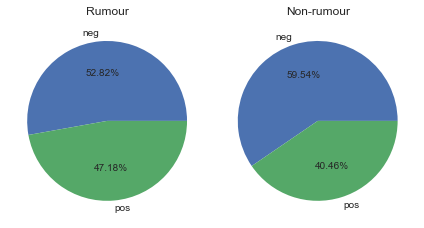

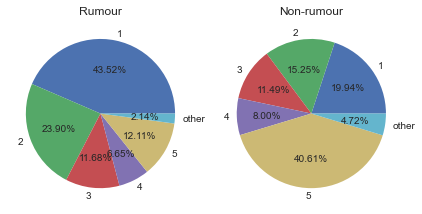

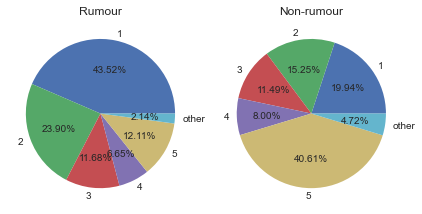

In [5]:
# sentimental_score
curr = rumour_df['sentimental_score'].value_counts()
plt.subplot(121)
plt.pie(curr.values,labels=curr.index,autopct='%1.2f%%')
plt.title("Rumour" )

plt.subplot(122)
curr = non_rumour_df['sentimental_score'].value_counts()
plt.pie(curr.values,labels=curr.index,autopct='%1.2f%%')
plt.title("Non-rumour")

plt.tight_layout()
plt.show()



# tweet_length
curr = fix_data(rumour_df['tweet_length'].value_counts())

plt.subplot(121)
plt.pie(curr.values,labels=curr.index,autopct='%1.2f%%')
plt.title("Rumour" )

plt.subplot(122)
curr = fix_data(non_rumour_df['tweet_length'].value_counts())
plt.pie(curr.values,labels=curr.index,autopct='%1.2f%%')
plt.title("Non-rumour")

plt.tight_layout()
plt.show()



# tweet_length
curr = fix_data(rumour_df['tweet_length'].value_counts())

plt.subplot(121)
plt.pie(curr.values,labels=curr.index,autopct='%1.2f%%')
plt.title("Rumour" )

plt.subplot(122)
curr = fix_data(non_rumour_df['tweet_length'].value_counts())
plt.pie(curr.values,labels=curr.index,autopct='%1.2f%%')
plt.title("Non-rumour")

plt.tight_layout()
plt.show()

In [6]:
curr

1        3240
2        2477
3        1866
4        1299
5        6597
other     766
Name: tweet_length, dtype: int64

In [7]:
# hashtags
from collections import Counter

def get_hashtags_data(df,name):

    def get_count_list(l):
        cnt = Counter()
        for i in l:
            cnt.update(i)
        return cnt

    dic = df.groupby('label')['hashtags'].agg(get_count_list)[name]
    df = pd.DataFrame(list(dic.items()), columns=['hashtags','count'])
    total = df['count'].sum()
    df['count'] = df['count'] / total

    df.sort_values(by=['count'],ascending=False, inplace=True)


    # other = df['count'][df['count'] <=30].sum()
    # df = df.loc[df['count'] >30]
    # df = df.append({'hashtags':'other', 'count': other}, ignore_index=True)
    return df.iloc[:20]


df = get_hashtags_data(non_rumour_df,'non-rumour')
df

,hashtags,count
1,COVID19,0.248358
5,coronavirus,0.104722
7,Coronavirus,0.025158
34,Covid19,0.023175
100,covid19,0.015244
24,BREAKING,0.009914
126,CoronaVirus,0.006444
115,China,0.005701
114,COVIDー19,0.005329
25,CoronavirusPandemic,0.004957


In [8]:
df = get_hashtags_data(rumour_df,'rumour')
df

,hashtags,count
3,COVID19,0.217039
0,coronavirus,0.127789
111,Covid19,0.024341
10,Coronavirus,0.024341
13,covid19,0.022312
26,BREAKING,0.018256
4,StayHome,0.010142
28,COVIDー19,0.008114
72,COVID19PH,0.006085
186,WATCH,0.006085


In [9]:

def contain_watch(l):
    if 'WATCH' in l:
        return True
    else:
        return False
rumour_df.loc[rumour_df['hashtags'].astype(str).str.contains('WATCH')]['text'].to_list()

["#WATCH Karnataka: Body of a man was carried on a cart by his family, for last rites, in Belagavi's Athani Taluk after they allegedly received no help from anyone. They allegedly received no help from others following a suspicion that the deceased was COVID-19 positive. (17.07) https://t.co/eRkeBDSB4v",
 '#WATCH Delhi: Doctors and staff of LNJP hospital allege that a group of #COVID19 patients who were brought to the hospital through CATS ambulance today, threatened and manhandled them when the staff asked them to wait for a while. (Source: LNJP Staff) https://t.co/3Cip4fSPgR',
 '#WATCH There is transmission in the community, but if it is community transmission or not that can be declared by Centre only, it is a technical term: Delhi Health Minister Satyendra Jain. #COVID19 https://t.co/ltJV7hYUxa']

In [11]:
rumour_df.loc[rumour_df['hashtags'].astype(str).str.contains('WashYourHands')]['text'].to_list()
# rumour_df['text'].to_list()

['God is NOT punishing us with the Corona Virus. The #Loamyword. Receiveee. \n#COVID19 #WashYourHands #StayHome https://t.co/dRDSGAOd9W',
 'An important public announcement from Sergeant Jack Beattie👮\u200d♂️ #Stayathome #StayAtHomeAndStaySafe #TogetherAtHome #COVID19 #SocialDistancing #WashYourHands https://t.co/JVOEZXkNGE']